In [10]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Cargar datos

In [11]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip satellite-image-classification.zip

**About Dataset**

**Context**

Satellite image Classification Dataset-RSI-CB256 , This dataset has 4 different classes mixed from Sensors and google map snapshot

**Content**

The past years have witnessed great progress on remote sensing (RS) image interpretation and its wide applications. With RS images becoming more accessible than ever before, there is an increasing demand for the automatic interpretation of these images. In this context, the benchmark datasets serve as essential prerequisites for developing and testing intelligent interpretation algorithms. After reviewing existing benchmark datasets in the research community of RS image interpretation, this article discusses the problem of how to efficiently prepare a suitable benchmark dataset for RS image interpretation. Specifically, we first analyze the current challenges of developing intelligent algorithms for RS image interpretation with bibliometric investigations. We then present the general guidance on creating benchmark datasets in efficient manners. Following the presented guidance, we also provide an example on building RS image dataset, i.e., Million-AID, a new large-scale benchmark dataset containing a million instances for RS image scene classification. Several challenges and perspectives in RS image annotation are finally discussed to facilitate the research in benchmark dataset construction. We do hope this paper will provide the RS community an overall perspective on constructing large-scale and practical image datasets for further research, especially data-driven ones.

**Acknowledgements**

Annotated Datasets for RS Image Interpretation
The interpretation of RS images has been playing an increasingly important role in a large diversity of applications, and thus, has attracted remarkable research attentions. Consequently, various datasets have been built to advance the development of interpretation algorithms for RS images. Covering literature published over the past decade, we perform a systematic review of the existing RS image datasets concerning the current mainstream of RS image interpretation tasks, including scene classification, object detection, semantic segmentation and change detection.

**Inspiration**

Artificial Intelligence, Computer Vision, Image Processing, Deep Learning, Satellite Image, Remote Sensing

# Etiquetado de las imágenes y Split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = '/content/data'

# Crear listas para las imágenes y sus etiquetas
images = []
labels = []

# Recorrer las subcarpetas
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            images.append(img_path)
            labels.append(class_name)

# Dividir los datos en entrenamiento, prueba y validación
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Función para copiar imágenes a nuevas carpetas
def copy_images(image_paths, labels, destination_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(destination_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

# Crear carpetas para train, val y test
base_dir = 'nuevo_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

copy_images(train_images, train_labels, train_dir)
copy_images(val_images, val_labels, val_dir)
copy_images(test_images, test_labels, test_dir)

print("Dataset dividido y copiado en carpetas 'train', 'val' y 'test'.")

# Preparación del dataset

In [ ]:
# Directorios del dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/nuevo_dataset/train'
val_dir = '/content/nuevo_dataset/val'
test_dir = '/content/nuevo_dataset/test'

# Configuración de los generadores de datos
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generadores de datos
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)


Found 3941 images belonging to 4 classes.
Found 845 images belonging to 4 classes.
Found 845 images belonging to 4 classes.


# Muestra de los datos

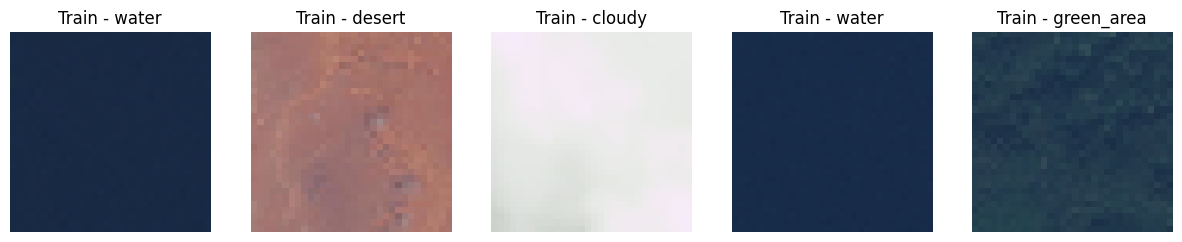

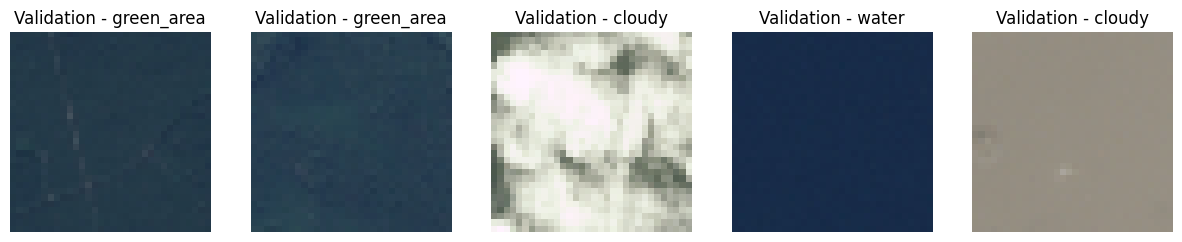

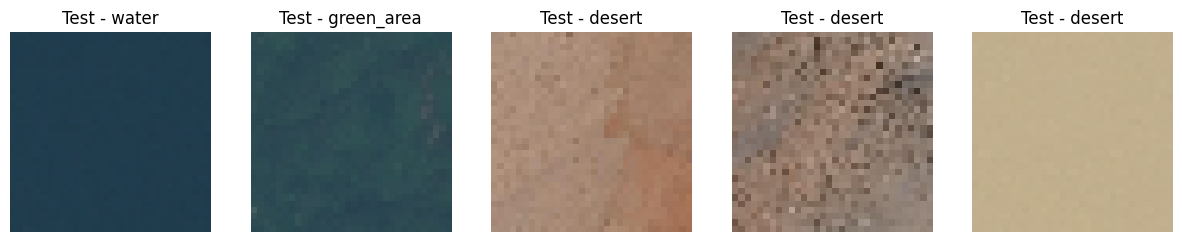

In [ ]:
def show_images(generator, title):
    images, labels = next(generator)  # Obtén el primer lote de imágenes y etiquetas
    plt.figure(figsize=(15, 5))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'{title} - {list(generator.class_indices.keys())[labels[i].argmax()]}')
        plt.axis('off')
    plt.show()

# Mostrar las primeras cinco imágenes del generador de entrenamiento
show_images(train_generator, 'Train')

# Mostrar las primeras cinco imágenes del generador de validación
show_images(val_generator, 'Validation')

# Mostrar las primeras cinco imágenes del generador de prueba
show_images(test_generator, 'Test')

# Modelo

In [7]:
from tensorflow.keras import layers, models, regularizers
# Definir el modelo de CNN
model = model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Añadir Dropout con una tasa del 50%
    layers.Dense(4, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
123/123 [==============================] - 19s 132ms/step - loss: 0.6430 - accuracy: 0.6536 - val_loss: 0.4498 - val_accuracy: 0.7344
Epoch 2/30
123/123 [==============================] - 11s 90ms/step - loss: 0.4531 - accuracy: 0.7859 - val_loss: 0.3873 - val_accuracy: 0.8149
Epoch 3/30
123/123 [==============================] - 9s 75ms/step - loss: 0.3911 - accuracy: 0.8312 - val_loss: 0.2934 - val_accuracy: 0.8630
Epoch 4/30
123/123 [==============================] - 10s 85ms/step - loss: 0.3324 - accuracy: 0.8590 - val_loss: 0.2581 - val_accuracy: 0.8918
Epoch 5/30
123/123 [==============================] - 10s 85ms/step - loss: 0.3334 - accuracy: 0.8552 - val_loss: 0.3250 - val_accuracy: 0.8462
Epoch 6/30
123/123 [==============================] - 9s 76ms/step - loss: 0.2981 - accuracy: 0.8729 - val_loss: 0.2552 - val_accuracy: 0.9038
Epoch 7/30
123/123 [==============================] - 11s 88ms/step - loss: 0.3237 - accuracy: 0.8608 - val_loss: 0.3292 - val_accuracy: 

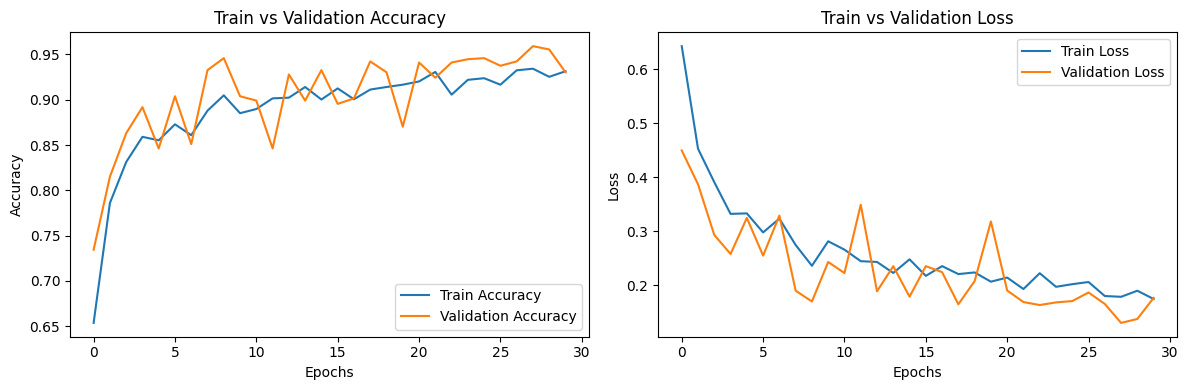

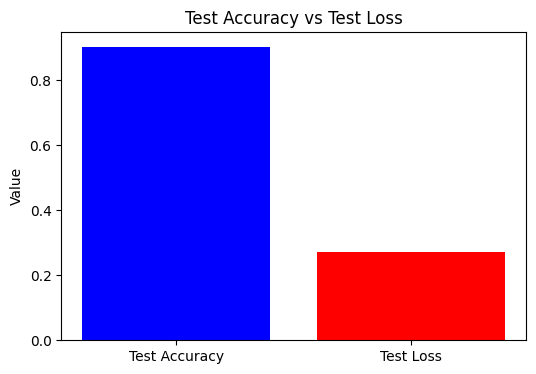

In [8]:
import matplotlib.pyplot as plt
# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()

# Métricas

27/27 [==============================] - 1s 47ms/step


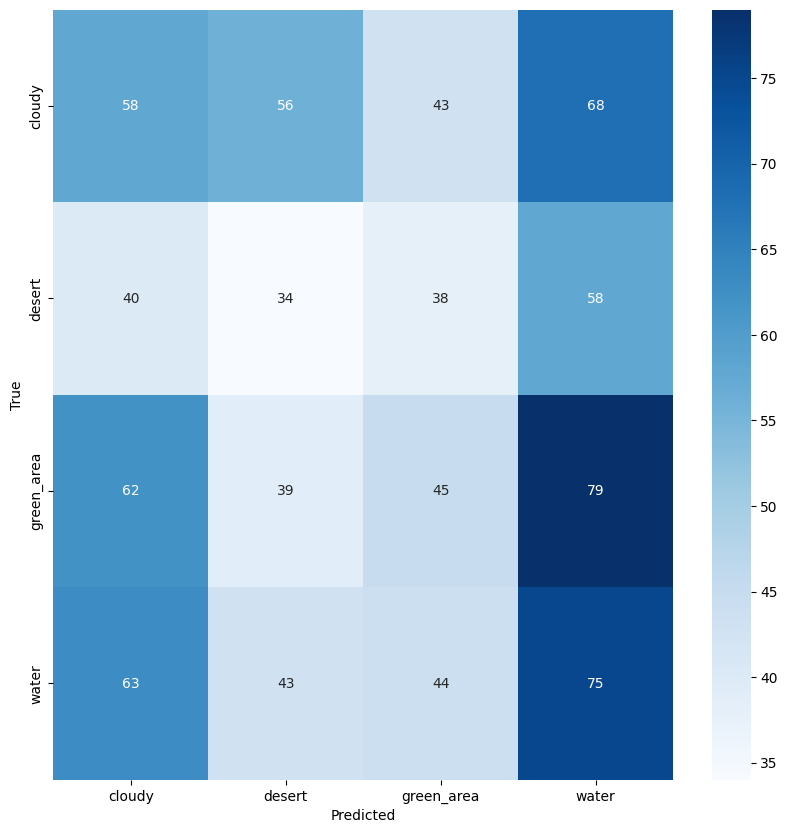

In [19]:

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
predictions = model.predict(test_generator,steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_generator.labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cloudy','desert','green_area','water'], yticklabels=['cloudy','desert','green_area','water'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
test_generator.classes

array([[2.5693366e-02, 9.7430664e-01, 6.4322716e-09, 1.3071848e-08],
       [6.7289963e-02, 9.3270952e-01, 2.3973817e-07, 2.7415277e-07],
       [4.8217598e-06, 1.2059515e-08, 9.6874344e-01, 3.1251594e-02],
       ...,
       [1.2674710e-07, 9.9999988e-01, 9.2313332e-21, 4.8082026e-16],
       [1.2710962e-05, 1.0551327e-08, 9.9623030e-01, 3.7569683e-03],
       [1.3435586e-05, 1.4311671e-07, 1.5668457e-02, 9.8431802e-01]],
      dtype=float32)

In [20]:
print(classification_report(test_generator.labels, predicted_labels, target_names=['cloudy','desert','green_area','water']))

              precision    recall  f1-score   support

      cloudy       0.26      0.26      0.26       225
      desert       0.20      0.20      0.20       170
  green_area       0.26      0.20      0.23       225
       water       0.27      0.33      0.30       225

    accuracy                           0.25       845
   macro avg       0.25      0.25      0.25       845
weighted avg       0.25      0.25      0.25       845



27/27 [==============================] - 2s 76ms/step


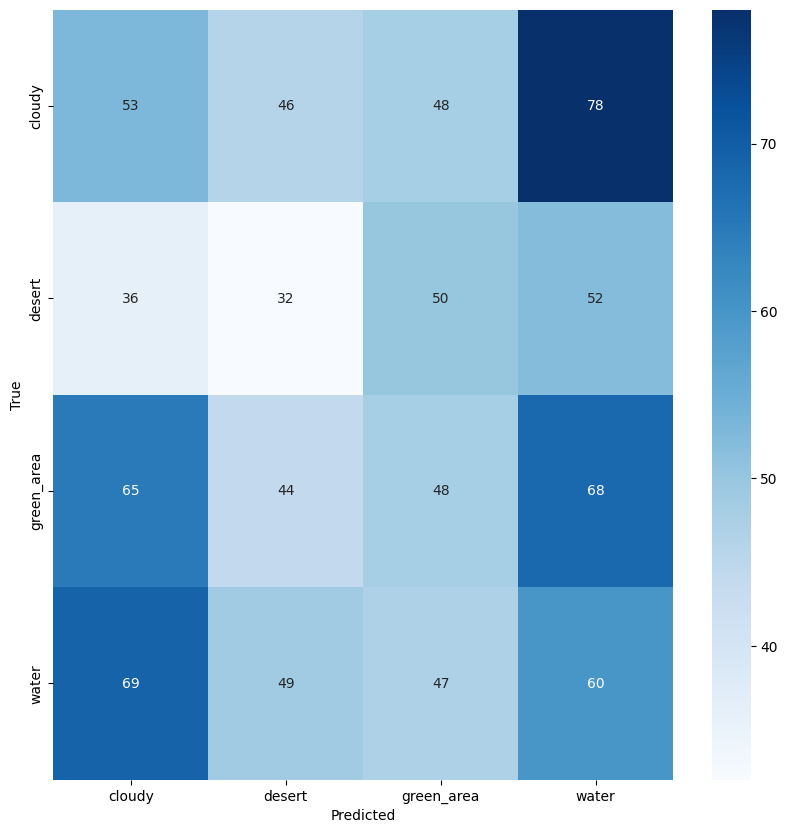

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
val_generator.reset()
predictions = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(val_generator.labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cloudy','desert','green_area','water'], yticklabels=['cloudy','desert','green_area','water'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
print(classification_report(val_generator.labels, predicted_labels, target_names=['cloudy','desert','green_area','water']))

              precision    recall  f1-score   support

      cloudy       0.24      0.24      0.24       225
      desert       0.19      0.19      0.19       170
  green_area       0.25      0.21      0.23       225
       water       0.23      0.27      0.25       225

    accuracy                           0.23       845
   macro avg       0.23      0.23      0.23       845
weighted avg       0.23      0.23      0.23       845



### CURVA ROC

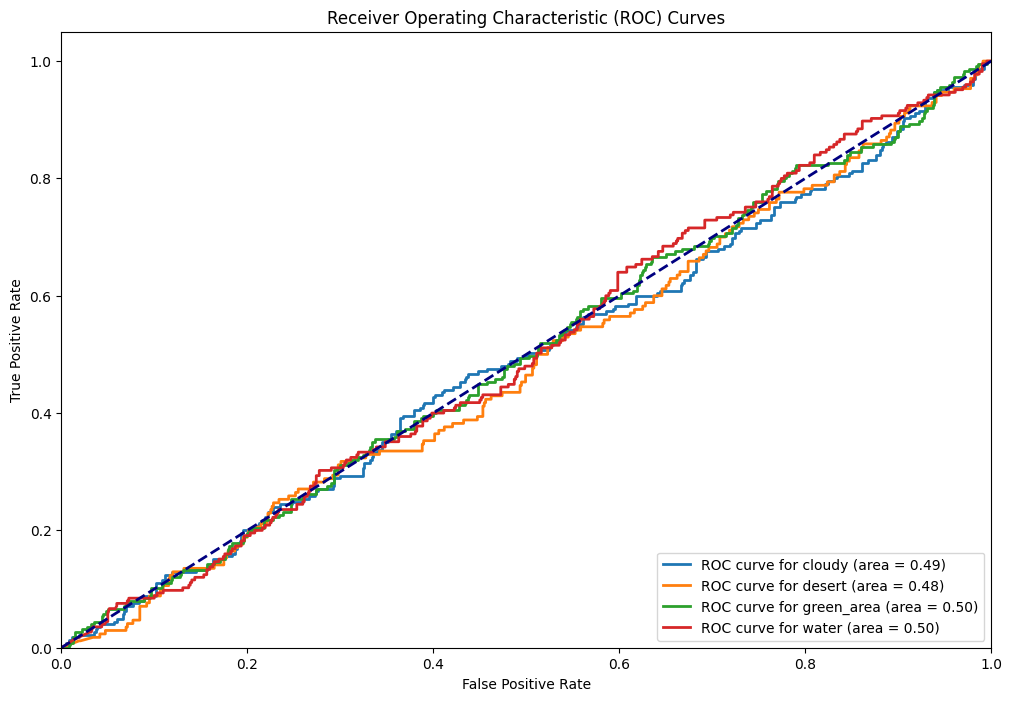

In [21]:
from sklearn.preprocessing import label_binarize
target_names = ['cloudy', 'desert', 'green_area', 'water']
true_labels_binarized = label_binarize(test_generator.classes, classes=[0, 1, 2, 3])

# Configuración de las curvas ROC
plt.figure(figsize=(12, 8))

for i in range(len(target_names)):
    fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for {target_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

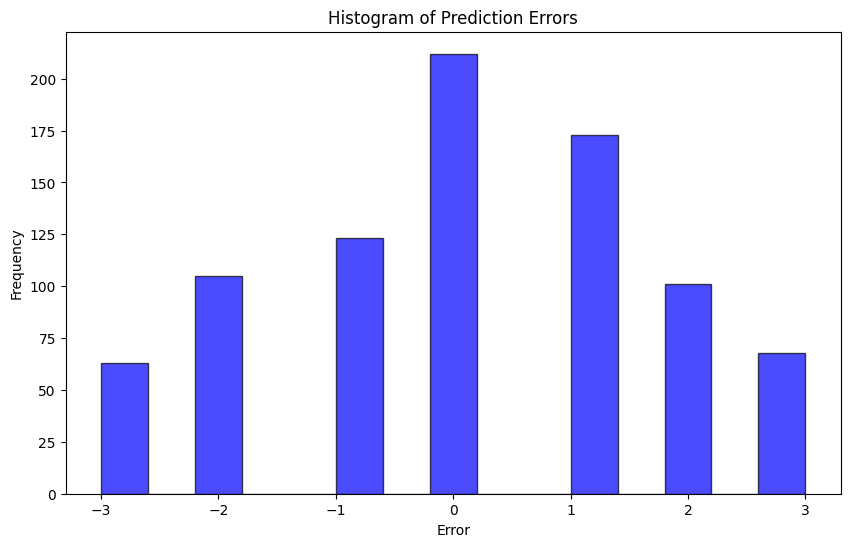

In [28]:
# Calcular los errores
errors = predicted_labels - test_generator.labels

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()
